In [2]:
# Imports and Setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Set up paths
PROJECT_ROOT = Path.cwd()
RAW_DATA = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DATA = PROJECT_ROOT / 'data' / 'processed'

print(f"Loading data from: {RAW_DATA}")

Loading data from: /Users/lukehatchl/Development/Personal/covid-spatial-analysis/data/raw


In [3]:
# Load the data we collected
# Load COVID data
covid_df = pd.read_csv(RAW_DATA / 'nyt_covid_counties.csv')
print(f"✓ Loaded COVID data: {len(covid_df):,} rows")

# Load county shapefile
counties_gdf = gpd.read_file(RAW_DATA / 'tl_2020_us_county.shp')
print(f"✓ Loaded counties: {len(counties_gdf):,} counties")

✓ Loaded COVID data: 2,502,832 rows
✓ Loaded counties: 3,234 counties


In [4]:
# Explore the data structures
print("="*60)
print("COVID DATA STRUCTURE")
print("="*60)
print(covid_df.head())
print(f"\nColumns: {list(covid_df.columns)}")
print(f"\nDate range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"States: {covid_df['state'].nunique()}")

print("\n" + "="*60)
print("SHAPEFILE STRUCTURE")
print("="*60)
print(counties_gdf.head())
print(f"\nColumns: {list(counties_gdf.columns)}")
print(f"\nCRS: {counties_gdf.crs}")

COVID DATA STRUCTURE
         date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1     0.0
1  2020-01-22  Snohomish  Washington  53061.0      1     0.0
2  2020-01-23  Snohomish  Washington  53061.0      1     0.0
3  2020-01-24       Cook    Illinois  17031.0      1     0.0
4  2020-01-24  Snohomish  Washington  53061.0      1     0.0

Columns: ['date', 'county', 'state', 'fips', 'cases', 'deaths']

Date range: 2020-01-21 to 2022-05-13
States: 56

SHAPEFILE STRUCTURE
  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06    

In [5]:
# Filter to one state for MVP
# Choose your state: 'California', 'Texas', or 'Florida'
FOCUS_STATE = 'California'  # Change this to your preference

print(f"Filtering data to {FOCUS_STATE}...")

# Filter COVID data
covid_state = covid_df[covid_df['state'] == FOCUS_STATE].copy()
print(f"✓ COVID data: {len(covid_state):,} rows for {FOCUS_STATE}")
print(f"  Counties: {covid_state['county'].nunique()}")
print(f"  Date range: {covid_state['date'].min()} to {covid_state['date'].max()}")

# Filter shapefile (need to get state FIPS code first)
# California = 06, Texas = 48, Florida = 12
STATE_FIPS = {'California': '06', 'Texas': '48', 'Florida': '12'}
counties_state = counties_gdf[counties_gdf['STATEFP'] == STATE_FIPS[FOCUS_STATE]].copy()
print(f"✓ Shapefile: {len(counties_state)} counties for {FOCUS_STATE}")

Filtering data to California...
✓ COVID data: 45,693 rows for California
  Counties: 59
  Date range: 2020-01-25 to 2022-05-13
✓ Shapefile: 58 counties for California


In [6]:
# Clean FIPS codes and check alignment
print("="*60)
print("CLEANING FIPS CODES")
print("="*60)

# COVID FIPS: Add leading zeros to make 5-digit codes
covid_state['fips'] = covid_state['fips'].astype('Int64').astype(str).str.zfill(5)

# Shapefile FIPS: Already correct format, just ensure string
counties_state['GEOID'] = counties_state['GEOID'].astype(str)

print("✓ FIPS codes formatted with leading zeros")
print(f"  Example COVID FIPS: {covid_state['fips'].iloc[0]}")
print(f"  Example Shapefile GEOID: {counties_state['GEOID'].iloc[0]}")

print("\n" + "="*60)
print("CHECKING FIPS CODE ALIGNMENT")
print("="*60)

# COVID FIPS codes
covid_fips = set(covid_state['fips'].dropna())
print(f"COVID data unique FIPS: {len(covid_fips)}")

# Shapefile FIPS codes (GEOID column)
shapefile_fips = set(counties_state['GEOID'])
print(f"Shapefile unique FIPS: {len(shapefile_fips)}")

# Check overlap
in_both = covid_fips.intersection(shapefile_fips)
only_covid = covid_fips - shapefile_fips
only_shapefile = shapefile_fips - covid_fips

print(f"\n✓ Counties in both datasets: {len(in_both)}")
print(f"⚠ Only in COVID data: {len(only_covid)}")
print(f"⚠ Only in shapefile: {len(only_shapefile)}")

if only_covid:
    print(f"\nExample FIPS only in COVID: {list(only_covid)[:5]}")
if only_shapefile:
    print(f"Example FIPS only in shapefile: {list(only_shapefile)[:5]}")

CLEANING FIPS CODES
✓ FIPS codes formatted with leading zeros
  Example COVID FIPS: 06059
  Example Shapefile GEOID: 06091

CHECKING FIPS CODE ALIGNMENT
COVID data unique FIPS: 58
Shapefile unique FIPS: 58

✓ Counties in both datasets: 58
⚠ Only in COVID data: 0
⚠ Only in shapefile: 0


In [7]:
# Convert date to datetime and define snapshot dates
covid_state['date'] = pd.to_datetime(covid_state['date'])

SNAPSHOT_DATES = {
    'Early Pandemic': '2020-04-15',
    'Winter Peak': '2021-01-15', 
    'Later Stage': '2021-10-15'
}

print("✓ Dates converted to datetime")
print("\nSnapshot dates for analysis:")
for name, date in SNAPSHOT_DATES.items():
    print(f"  {name}: {date}")

# Filter COVID data to these dates
snapshots = {}
for name, date in SNAPSHOT_DATES.items():
    snapshot = covid_state[covid_state['date'] == date].copy()
    snapshots[name] = snapshot
    print(f"\n{name} ({date}):")
    print(f"  Rows: {len(snapshot)}")
    print(f"  Total cases: {snapshot['cases'].sum():,.0f}")
    print(f"  Total deaths: {snapshot['deaths'].sum():,.0f}")

✓ Dates converted to datetime

Snapshot dates for analysis:
  Early Pandemic: 2020-04-15
  Winter Peak: 2021-01-15
  Later Stage: 2021-10-15

Early Pandemic (2020-04-15):
  Rows: 53
  Total cases: 27,107
  Total deaths: 885

Winter Peak (2021-01-15):
  Rows: 58
  Total cases: 2,937,860
  Total deaths: 32,947

Later Stage (2021-10-15):
  Rows: 58
  Total cases: 4,828,318
  Total deaths: 70,766


In [8]:
# Merge each snapshot with shapefile
merged_snapshots = {}

for name, snapshot_df in snapshots.items():
    # Merge COVID data with county boundaries
    merged = counties_state.merge(
        snapshot_df,
        left_on='GEOID',
        right_on='fips',
        how='left'  # Keep all counties even if no COVID data
    )
    
    # Fill NaN values with 0 (counties with no reported cases)
    merged['cases'] = merged['cases'].fillna(0)
    merged['deaths'] = merged['deaths'].fillna(0)
    
    merged_snapshots[name] = merged
    
    print(f"\n{name}:")
    print(f"  Merged rows: {len(merged)}")
    print(f"  Counties with cases: {(merged['cases'] > 0).sum()}")
    print(f"  Max cases in a county: {merged['cases'].max():,.0f}")


Early Pandemic:
  Merged rows: 58
  Counties with cases: 53
  Max cases in a county: 10,496

Winter Peak:
  Merged rows: 58
  Counties with cases: 58
  Max cases in a county: 990,326

Later Stage:
  Merged rows: 58
  Counties with cases: 58
  Max cases in a county: 1,476,398


In [ ]:
# Add population data for rate calculations
# Get population from shapefile (ALAND is land area, we need population)
# Note: The shapefile doesn't have population - we'll need to add this

# For MVP, let's calculate cases per square mile instead
# Or we can skip rates for now and just map raw cases

# Add area in square miles
merged_snapshots_with_area = {}
for name, merged in merged_snapshots.items():
    merged['area_sqmi'] = merged['ALAND'] / 2589988.110336  # Convert sq meters to sq miles
    merged['cases_per_sqmi'] = merged['cases'] / merged['area_sqmi']
    merged['cases_per_sqmi'] = merged['cases_per_sqmi'].replace([np.inf, -np.inf], 0)
    merged_snapshots_with_area[name] = merged

print("✓ Added area calculations")
print("\nNote: For true rate calculations (per 100k population),")
print("we'll need to add Census population data later.")

✓ Added area calculations

Note: For true rate calculations (per 100k population),
we'll need to add Census population data later.


In [10]:
# Save processed data
for name, merged in merged_snapshots_with_area.items():
    filename = f"{FOCUS_STATE.lower()}_{name.lower().replace(' ', '_')}_snapshot.geojson"
    filepath = PROCESSED_DATA / filename
    
    # Save as GeoJSON for easy loading later
    merged.to_file(filepath, driver='GeoJSON')
    print(f"✓ Saved {name} to {filepath}")

print(f"\n{'='*60}")
print("DATA CLEANING COMPLETE!")
print(f"{'='*60}")
print(f"State: {FOCUS_STATE}")
print(f"Snapshots: {len(merged_snapshots_with_area)}")
print(f"Saved to: {PROCESSED_DATA}")

✓ Saved Early Pandemic to /Users/lukehatchl/Development/Personal/covid-spatial-analysis/data/processed/california_early_pandemic_snapshot.geojson
✓ Saved Winter Peak to /Users/lukehatchl/Development/Personal/covid-spatial-analysis/data/processed/california_winter_peak_snapshot.geojson
✓ Saved Later Stage to /Users/lukehatchl/Development/Personal/covid-spatial-analysis/data/processed/california_later_stage_snapshot.geojson

DATA CLEANING COMPLETE!
State: California
Snapshots: 3
Saved to: /Users/lukehatchl/Development/Personal/covid-spatial-analysis/data/processed


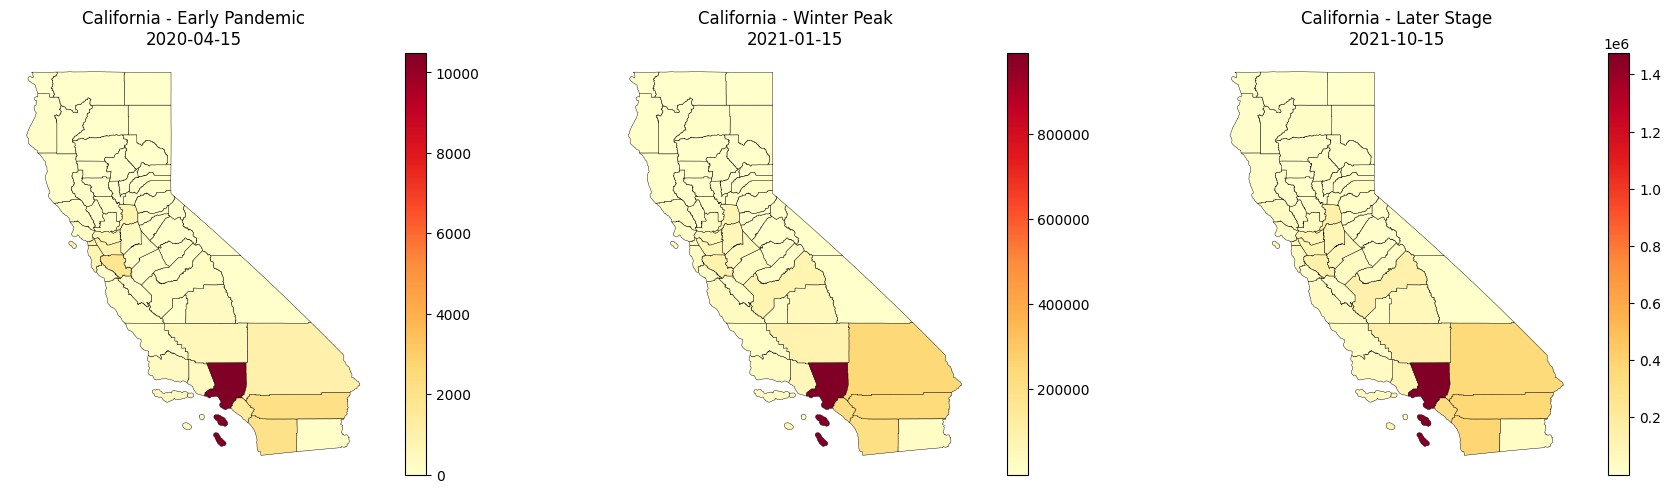

✓ Preview map saved to outputs/figures/


In [12]:
# Quick visualization test
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, merged) in enumerate(merged_snapshots_with_area.items()):
    ax = axes[idx]
    merged.plot(column='cases', 
                cmap='YlOrRd', 
                legend=True,
                ax=ax,
                edgecolor='black',
                linewidth=0.3)
    ax.set_title(f'{FOCUS_STATE} - {name}\n{SNAPSHOT_DATES[name]}')
    ax.axis('off')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'outputs' / 'figures' / 'mvp_snapshots_preview.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Preview map saved to outputs/figures/")